In [1]:
import os
import errno

import numpy as np
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras import backend as K

from deepcell.utils.data_utils import make_training_data
from deepcell.utils.data_utils import get_data
from deepcell.utils.train_utils import rate_scheduler
from deepcell.model_zoo import bn_feature_net_61x61
from deepcell.model_zoo import dilated_bn_feature_net_61x61
from deepcell.model_zoo import bn_dense_feature_net
from deepcell.training import train_model_conv, train_model_sample
from deepcell.utils.export_utils import export_model

Using TensorFlow backend.


# Fully Convolutional Training

In [2]:
# data options
DATA_OUTPUT_MODE = 'conv'
PADDING = 'same'
RESIZE = True
RESHAPE_SIZE = 512

# filepath constants 
DATA_DIR = '/data/data'
MODEL_DIR = '/data/models'
NPZ_DIR = '/data/npz_data'
RESULTS_DIR = '/data/results'
EXPORT_DIR = '/data/exports'
PREFIX = 'cells/ecoli/kc'
CONV_DATA_FILE = 'ecoli_kc_{}_{}'.format(K.image_data_format(), DATA_OUTPUT_MODE)

# Check for channels_first or channels_last
IS_CHANNELS_FIRST = K.image_data_format() == 'channels_first'

ROW_AXIS = 2 if IS_CHANNELS_FIRST else 1
COL_AXIS = 3 if IS_CHANNELS_FIRST else 2
CHANNEL_AXIS = 1 if IS_CHANNELS_FIRST else 3

# create these directories if they do not exist
for d in (NPZ_DIR, MODEL_DIR, RESULTS_DIR):
    try:
        os.makedirs(os.path.join(d, PREFIX))
        print('Created new directory:', os.path.join(d, PREFIX))
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

In [3]:
# Create the training data
make_training_data(
    direc_name=os.path.join(DATA_DIR, PREFIX),
    dimensionality=2,
    max_training_examples=None, # Define maximum number of training examples
    window_size_x=30,
    window_size_y=30,
    padding=PADDING,
    file_name_save=os.path.join(NPZ_DIR, PREFIX, CONV_DATA_FILE),
    training_direcs=['set1', 'set2'],
    channel_names=['phase'],
    num_of_features=2,
    raw_image_direc='processed',
    annotation_direc='annotated_old',
    reshape_size=RESHAPE_SIZE if RESIZE else None,
    edge_feature=[1, 0, 0],  # Specify which feature is the edge feature
    dilation_radius=1,
    output_mode=DATA_OUTPUT_MODE)

if os.path.isfile(os.path.join(NPZ_DIR, PREFIX, CONV_DATA_FILE) + '.npz'):
    print('Data Saved to', os.path.join(NPZ_DIR, PREFIX, CONV_DATA_FILE) + '.npz')
else:
    raise Exception('Uh Oh!  Your data file did not save properly :(')

Reshaped feature data from (2, 1002, 1004, 3) to (8, 512, 512, 3)
Reshaped training data from (2, 1002, 1004, 1) to (8, 512, 512, 1)
Data Saved to /data/npz_data/cells/ecoli/kc/ecoli_kc_channels_last_conv.npz


In [4]:
# Load the training data from NPZ into a numpy array
training_data = np.load(os.path.join(NPZ_DIR, PREFIX, CONV_DATA_FILE + '.npz'))

X, y = training_data['X'], training_data['y']
print('X.shape: {}\ny.shape: {}'.format(X.shape, y.shape))

# save the size of the input data for input_shape model parameter
size = (RESHAPE_SIZE, RESHAPE_SIZE) if RESIZE else X.shape[ROW_AXIS:COL_AXIS + 1]
if IS_CHANNELS_FIRST:
    input_shape = (X.shape[CHANNEL_AXIS], size[0], size[1])
else:
    input_shape = (size[0], size[1], X.shape[CHANNEL_AXIS])
    
# Set up other training parameters
n_epoch = 32
batch_size = 1
optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.01, decay=0.99)

X.shape: (8, 512, 512, 1)
y.shape: (8, 512, 512, 3)


In [5]:
# First, create a foreground/background separation model

# Instantiate the model
conv_model = bn_dense_feature_net(
    n_features=3,
    input_shape=input_shape,
    reg=1e-5,
    norm_method='median')

# Train the model
train_model_conv(
    model=conv_model,
    dataset=CONV_DATA_FILE,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    direc_save=os.path.join(MODEL_DIR, PREFIX),
    direc_data=os.path.join(NPZ_DIR, PREFIX),
    lr_sched=lr_sched,
    class_weight=training_data['class_weights'],
    rotation_range=180,
    flip=True,
    shear=False)

X_train shape: (7, 512, 512, 1)
y_train shape: (7, 512, 512, 3)
X_test shape: (1, 512, 512, 1)
y_test shape: (1, 512, 512, 3)
Output Shape: (None, 512, 512, 3)
Number of Classes: 3
Using real-time data augmentation.
Epoch 1/32
6/7 [========================>.....] - ETA: 1s - loss: 0.9640 - acc: 0.4561
Epoch 00001: val_loss improved from inf to 0.95574, saving model to /data/models/cells/ecoli/kc/2018-08-23_ecoli_kc_channels_last_conv__0.h5
7/7 [==============================] - 9s 1s/step - loss: 0.9083 - acc: 0.4854 - val_loss: 0.9557 - val_acc: 0.5648
Epoch 2/32
6/7 [========================>.....] - ETA: 0s - loss: 0.5169 - acc: 0.6811
Epoch 00002: val_loss improved from 0.95574 to 0.91161, saving model to /data/models/cells/ecoli/kc/2018-08-23_ecoli_kc_channels_last_conv__0.h5
7/7 [==============================] - 2s 326ms/step - loss: 0.5026 - acc: 0.6906 - val_loss: 0.9116 - val_acc: 0.7545
Epoch 3/32
6/7 [========================>.....] - ETA: 0s - loss: 0.4815 - acc: 0.7471
Ep

Epoch 30/32
6/7 [========================>.....] - ETA: 0s - loss: 0.2419 - acc: 0.8665
Epoch 00030: val_loss improved from 0.72335 to 0.71880, saving model to /data/models/cells/ecoli/kc/2018-08-23_ecoli_kc_channels_last_conv__0.h5
7/7 [==============================] - 1s 209ms/step - loss: 0.2420 - acc: 0.8642 - val_loss: 0.7188 - val_acc: 0.8427
Epoch 31/32
6/7 [========================>.....] - ETA: 0s - loss: 0.2137 - acc: 0.8164
Epoch 00031: val_loss improved from 0.71880 to 0.66258, saving model to /data/models/cells/ecoli/kc/2018-08-23_ecoli_kc_channels_last_conv__0.h5
7/7 [==============================] - 1s 206ms/step - loss: 0.2219 - acc: 0.8094 - val_loss: 0.6626 - val_acc: 0.8556
Epoch 32/32
6/7 [========================>.....] - ETA: 0s - loss: 0.2360 - acc: 0.8603
Epoch 00032: val_loss did not improve
7/7 [==============================] - 1s 192ms/step - loss: 0.2407 - acc: 0.8453 - val_loss: 0.7005 - val_acc: 0.8458


In [6]:
# With the trained model, make predictions on testing data
training_data_file = os.path.join(NPZ_DIR, PREFIX, CONV_DATA_FILE + '.npz')

train_dict, test_dict = get_data(
    training_data_file, mode=DATA_OUTPUT_MODE, seed=21)

X_test, y_test = test_dict

test_images = conv_model.predict(X_test)

print('model output shape:', test_images.shape)

model output shape: (1, 512, 512, 3)


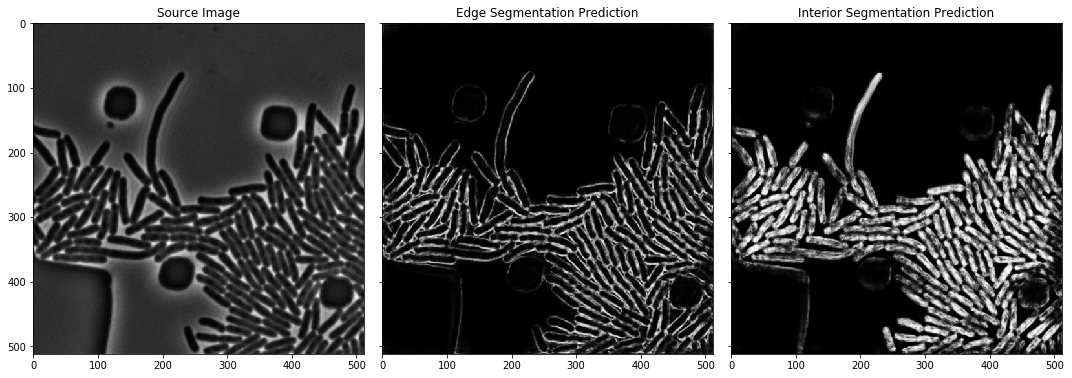

In [7]:
# Plot the results
import matplotlib.pyplot as plt

index = 0

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, :, :, 0], cmap='gray')
ax[0].set_title('Source Image')

ax[1].imshow(test_images[index, :, :, 0], cmap='gray')
ax[1].set_title('Edge Segmentation Prediction')

ax[2].imshow(test_images[index, :, :, 1], cmap='gray')
ax[2].set_title('Interior Segmentation Prediction')

fig.tight_layout()
plt.show()

# Sample Based Training

In [8]:
DATA_OUTPUT_MODE = 'sample'
PADDING = 'valid'
RESIZE = False
RESHAPE_SIZE = 512

# filepath constants
DATA_DIR = '/data/data'
MODEL_DIR = '/data/models'
NPZ_DIR = '/data/npz_data'
RESULTS_DIR = '/data/results'
EXPORT_DIR = '/data/exports'
PREFIX = 'cells/ecoli/kc'
SAMPLE_DATA_FILE = 'ecoli_kc_{}_{}'.format(K.image_data_format(), DATA_OUTPUT_MODE)

In [9]:
# Create the training data
make_training_data(
    direc_name=os.path.join(DATA_DIR, PREFIX),
    dimensionality=2,
    max_training_examples=None, # Define maximum number of training examples
    window_size_x=30,
    window_size_y=30,
    padding=PADDING,
    file_name_save=os.path.join(NPZ_DIR, PREFIX, SAMPLE_DATA_FILE),
    training_direcs=['set1', 'set2'],
    channel_names=['phase'],
    num_of_features=2,
    raw_image_direc='processed',
    annotation_direc='annotated_old',
    reshape_size=RESHAPE_SIZE if RESIZE else None,
    edge_feature=[1, 0, 0], # Specify which feature is the edge feature,
    dilation_radius=1,
    output_mode=DATA_OUTPUT_MODE)

if os.path.isfile(os.path.join(NPZ_DIR, PREFIX, SAMPLE_DATA_FILE) + '.npz'):
    print('Data Saved to', os.path.join(NPZ_DIR, PREFIX, SAMPLE_DATA_FILE) + '.npz')
else:
    raise Exception('Uh Oh!  Your data file did not save properly :(')

Data Saved to /data/npz_data/cells/ecoli/kc/ecoli_kc_channels_last_sample.npz


In [10]:
# Load the training data from NPZ into a numpy array
training_data = np.load(os.path.join(NPZ_DIR, PREFIX, SAMPLE_DATA_FILE + '.npz'))

X, y = training_data['X'], training_data['y']
print('X.shape: {}\ny.shape: {}'.format(X.shape, y.shape))

# Set up training parameters
n_epoch = 32
batch_size = 64
optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.01, decay=.99)

X.shape: (2, 1002, 1004, 1)
y.shape: (333348,)


In [11]:
# Instantiate the model
sample_model = bn_feature_net_61x61(
    n_features=3,
    reg=1e-5,
    norm_method='median',
    n_channels=X.shape[CHANNEL_AXIS])

# Train the model
train_model_sample(
    model=sample_model,
    dataset=SAMPLE_DATA_FILE,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    direc_save=os.path.join(MODEL_DIR, PREFIX),
    direc_data=os.path.join(NPZ_DIR, PREFIX),
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False)

Using feature net 61x61 with batch normalization
X_train shape: (300013, 61, 61, 1)
y_train shape: (300013,)
X_test shape: (33335, 61, 61, 1)
y_test shape: (33335,)
Output Shape: (None, 3)
Number of Classes: 3
Using real-time data augmentation.
Epoch 1/32
4686/4687 [============================>.] - ETA: 0s - loss: 0.4021 - acc: 0.8163
Epoch 00001: val_loss improved from inf to 0.29588, saving model to /data/models/cells/ecoli/kc/2018-08-23_ecoli_kc_channels_last_sample__0.h5
4687/4687 [==============================] - 140s 30ms/step - loss: 0.4021 - acc: 0.8163 - val_loss: 0.2959 - val_acc: 0.8641
Epoch 2/32
4686/4687 [============================>.] - ETA: 0s - loss: 0.3801 - acc: 0.8276
Epoch 00002: val_loss improved from 0.29588 to 0.27372, saving model to /data/models/cells/ecoli/kc/2018-08-23_ecoli_kc_channels_last_sample__0.h5
4687/4687 [==============================] - 138s 29ms/step - loss: 0.3801 - acc: 0.8276 - val_loss: 0.2737 - val_acc: 0.8992
Epoch 3/32
4685/4687 [=====

Epoch 29/32
4685/4687 [============================>.] - ETA: 0s - loss: 0.2079 - acc: 0.9204
Epoch 00029: val_loss did not improve
4687/4687 [==============================] - 136s 29ms/step - loss: 0.2079 - acc: 0.9204 - val_loss: 0.2299 - val_acc: 0.9111
Epoch 30/32
4686/4687 [============================>.] - ETA: 0s - loss: 0.2055 - acc: 0.9215
Epoch 00030: val_loss did not improve
4687/4687 [==============================] - 137s 29ms/step - loss: 0.2055 - acc: 0.9215 - val_loss: 0.2482 - val_acc: 0.9016
Epoch 31/32
4686/4687 [============================>.] - ETA: 0s - loss: 0.2028 - acc: 0.9227
Epoch 00031: val_loss did not improve
4687/4687 [==============================] - 138s 29ms/step - loss: 0.2028 - acc: 0.9226 - val_loss: 0.2465 - val_acc: 0.9021
Epoch 32/32
4686/4687 [============================>.] - ETA: 0s - loss: 0.2002 - acc: 0.9238
Epoch 00032: val_loss improved from 0.22419 to 0.21544, saving model to /data/models/cells/ecoli/kc/2018-08-23_ecoli_kc_channels_las

In [12]:
# With the trained models, make predictions on testing data
training_data_file = os.path.join(NPZ_DIR, PREFIX, CONV_DATA_FILE + '.npz')

train_dict, test_dict = get_data(
    training_data_file, mode='conv', seed=21)

X_test, y_test = test_dict#['X'], test_dict['y']

# Re-initializing dilated models for sample-mode predictions
sample_weights_file = '2018-08-23_ecoli_kc_channels_last_sample__0.h5'
sample_weights_file = os.path.join(MODEL_DIR, PREFIX, sample_weights_file)

run_sample_model = dilated_bn_feature_net_61x61(
    n_features=3,
    norm_method='median',
    input_shape=X_test.shape[1:])
run_sample_model.load_weights(sample_weights_file)

test_images = run_sample_model.predict(X_test)

print('model output shape:', test_images.shape)

Using dilated feature net 61x61 with batch normalization
model output shape: (1, 452, 452, 3)


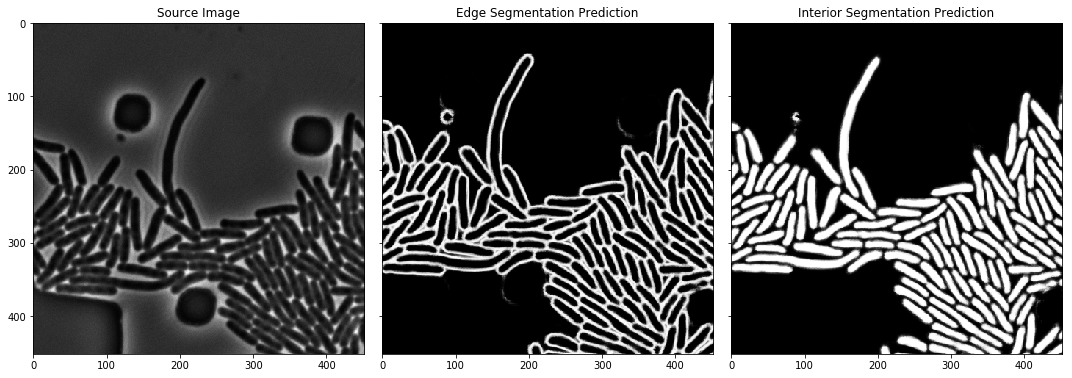

In [13]:
# Plot the results
import matplotlib.pyplot as plt

index = 0

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, :, :, 0], cmap='gray')
ax[0].set_title('Source Image')

ax[1].imshow(test_images[index, :, :, 0], cmap='gray')
ax[1].set_title('Edge Segmentation Prediction')

ax[2].imshow(test_images[index, :, :, 1], cmap='gray')
ax[2].set_title('Interior Segmentation Prediction')

fig.tight_layout()
plt.show()